# Predicting Litigation Outcomes of Civil Copyright Court Cases

This project provides a study of U.S. court outcome and opinions about fair use and copyright
civil cases by analyzing a dataset containing various features related to court cases, 
including text data, numerical data, and categorical data, building and evaluating
machine learning models to determine their predictive performance.


# Business understanding 

The U.S. Copyright Office defines copyright [https://www.copyright.gov/what-is-copyright/] as a "type of intellectual property that protects original works of authorship as soon as an author fixes the work in a tangible form of expression. In copyright law, there are a lot of different types of works, including paintings, photographs, illustrations, musical compositions, sound recordings, computer programs, books, poems, blog posts, movies, architectural works, plays," etc.. In addition, copyright infrigement involves the unauthorized use or reproduction, distribution, public display, creation or derivative of copyrighted works. <br>
<br>
However, there is no such thing as “global copyright laws.” Though, in some instances the use of copyrighted works is deemed 'fair use,' such as: parody, news reporting, commentary, impact on the market/public, and others. Litigation may occur among the parties owning the copyright and the parties that used or referenced the work.  
<br>
This system analyzes copyright infringement and copyright fair use legal cases brought in the U.S. courts and their outcome. It is important to understand fair use and copyright infringement to ensure the rights of the copyright holders are sustained while balancing public discurse and use for creative works.

**Imports**

In [1]:
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from textblob import TextBlob
from time import time

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML

# Overview

This analysis evaluates the predictive power of various machine learning models on a subset of civil cases, and focus on the litigation results of copyright found and fair use found cases specifically.<br>

At first I planned to use the Federal Judicial Center Civil Cases terminated between 2014 and 2023 (with 3557752 rows and 46 columns), and also with the fair use cases (with two datsets of 251 rows and 7 columns, and 251 rows and 9 columns). However, there was no obvious way to associate them with their corresponding opinions and tags (characteristics). Instead, I created a dataset file with copyright cases from Harvard Case Law (https://case.law/)

## Data Acquisition

In [3]:
data = pd.read_csv('data/consolidated_dataset_final_v2.csv', low_memory=False)

### Inspect the data

In [4]:
print('data: \n', data.columns)

data: 
 Index(['Unnamed: 0.1', 'Unnamed: 0', 'outcome', 'case_type_encoded', 'year',
       'court', 'jurisdiction', 'tags', 'text'],
      dtype='object')


In [5]:
print("Cases: ",data.shape ,"\n")
data.info()

Cases:  (1043, 9) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043 entries, 0 to 1042
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0.1       1043 non-null   int64  
 1   Unnamed: 0         1043 non-null   int64  
 2   outcome            1043 non-null   object 
 3   case_type_encoded  1043 non-null   int64  
 4   year               1043 non-null   float64
 5   court              1043 non-null   object 
 6   jurisdiction       1043 non-null   object 
 7   tags               900 non-null    object 
 8   text               1042 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 73.5+ KB


In [6]:
data.isnull().sum()

Unnamed: 0.1           0
Unnamed: 0             0
outcome                0
case_type_encoded      0
year                   0
court                  0
jurisdiction           0
tags                 143
text                   1
dtype: int64

In [7]:
data[['outcome','case_type_encoded','year','court','jurisdiction','tags']].head()

,outcome,case_type_encoded,year,court,jurisdiction,tags
0,copyright infringement found,0,2017.0,United States District Court for the Southern ...,2nd Circuit,"commentary, education, film, graphic, music, n..."
1,copyright infringement found,0,2013.0,United States District Court for the District ...,9th Circuit,"film, internet"
2,copyright infringement found,0,2014.0,United States Court of Appeals for the Second ...,2nd Circuit,"commentary, drawing, education, music, news re..."
3,copyright infringement not found,0,1987.0,United States District Court for the Northern ...,9th Circuit,"drawing, film, music, unpublished"
4,pending,0,2010.0,United States Court of Appeals for the Ninth C...,9th Circuit,"internet, photograph"


### Data Exploration

In [8]:
print("outcome: ",data['outcome'].unique())
print("\ncase_type: ",data['case_type_encoded'].unique())
print("\njurisdiction: ",data['jurisdiction'].unique())

outcome:  ['copyright infringement found' 'copyright infringement not found'
 'pending' 'fair use not found' 'fair use found']

case_type:  [0 1]

jurisdiction:  ['2nd Circuit' '9th Circuit' 'Federal Circuit' '11th Circuit'
 '3rd Circuit' '5th Circuit' '6th Circuit' '4th Circuit' '10th Circuit'
 '8th Circuit' 'U.S. Supreme Court' '7th Circuit'
 'District of Columbia Circuit' '1st Circuit' '-8']


#### Exploratory Data Analysis (EDA)

Text(1.2, 1.0, 'In this dataset the type of Copyright civil cases is pretty balanced between fair use (0) and copyright (1) cases')

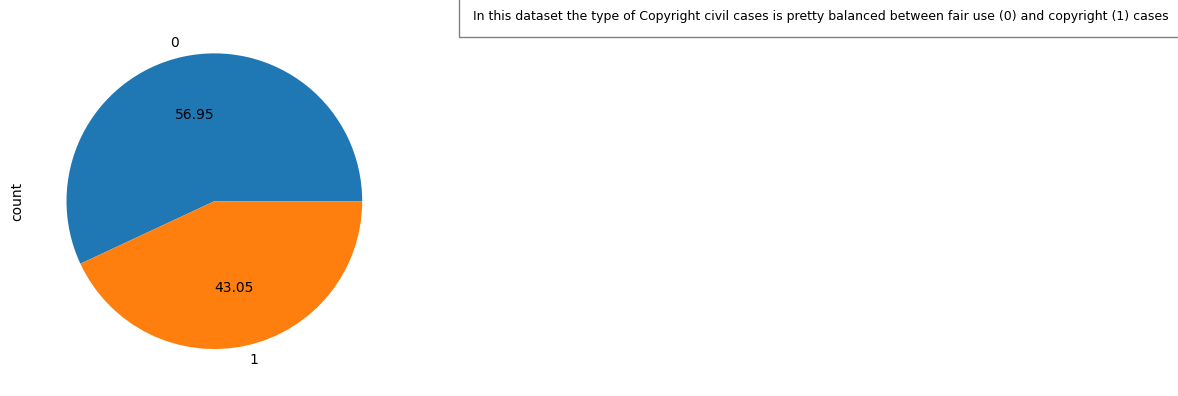

In [9]:
data['case_type_encoded'].value_counts().plot.pie(autopct="%.2f")
plt.annotate('In this dataset the type of Copyright civil cases is pretty balanced between fair use (0) and copyright (1) cases',
            xy = (1.2, 1.0),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=9,
             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

Text(1.2, 1.0, 'In this dataset the outcome for Copyright civil cases is split among copyright infringement found and not found \n and fair use found and not found')

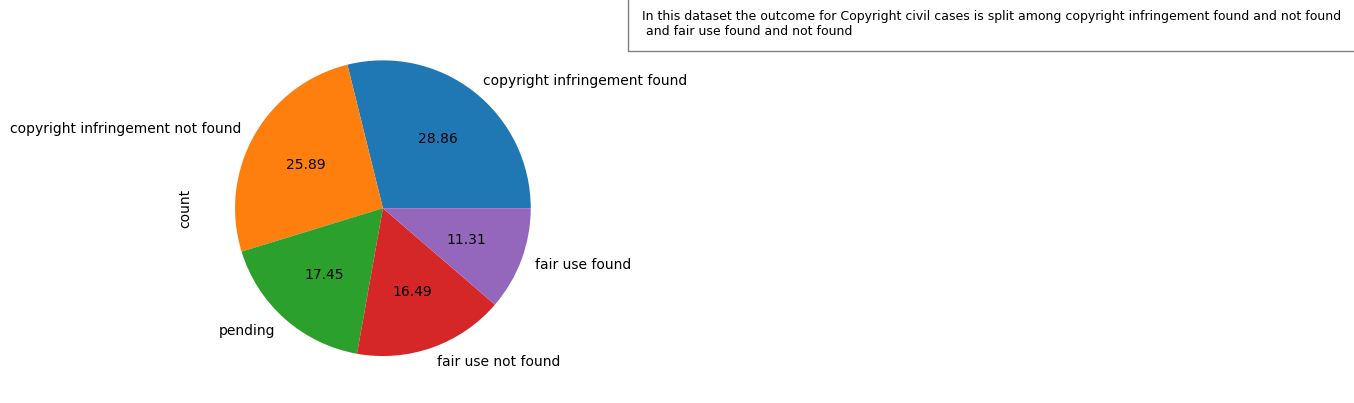

In [10]:
data['outcome'].value_counts().plot.pie(autopct="%.2f")
plt.annotate('In this dataset the outcome for Copyright civil cases is split among copyright infringement found and not found \n and fair use found and not found',
            xy = (1.2, 1.0),
            xycoords='axes fraction',
            ha='left',
            va="center",
            fontsize=9,
             bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

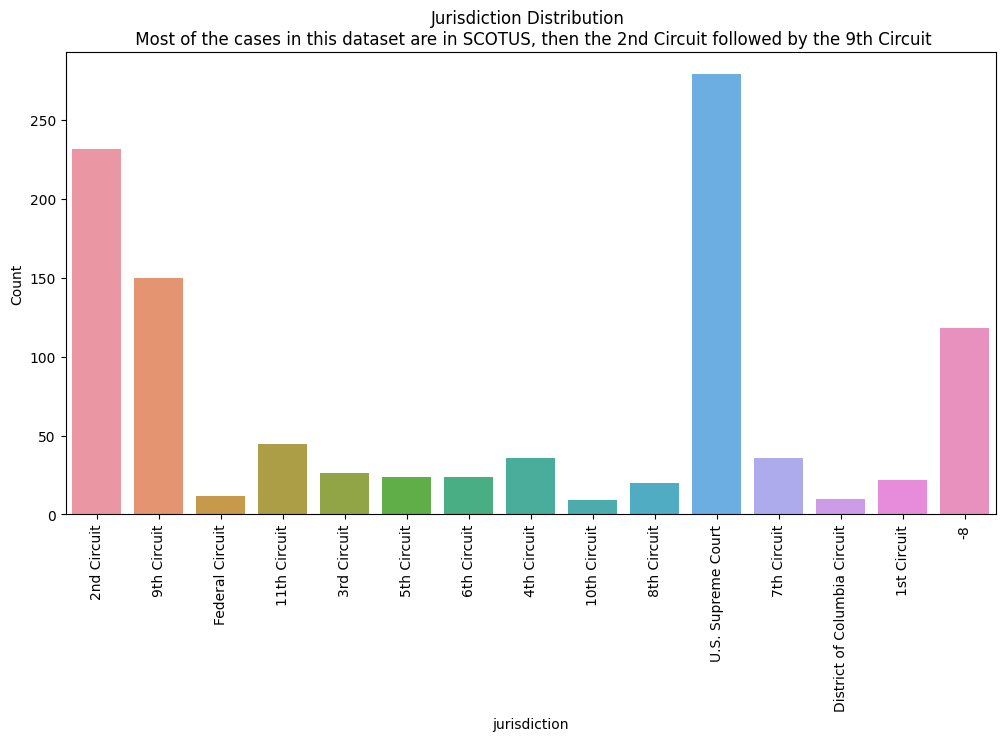

In [11]:
# Distribution of categorical column: 'jurisdiction'
plt.figure(figsize=(12, 6))
sns.countplot(x='jurisdiction', data=data)
plt.title('Jurisdiction Distribution \n Most of the cases in this dataset are in SCOTUS, then the 2nd Circuit followed by the 9th Circuit')
plt.xlabel('jurisdiction')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [12]:
data['year'] = data['year']
# Calculate the mean year, ignoring NaN values
mean_year = int(data['year'].mean())

# # Replace NaN values and very early years with the mean year
data['year'] = data['year'].fillna(mean_year)
data['year'] = data['year'].apply(lambda x: mean_year if x < 1950 else x)

# Round the 'year' column to the nearest integer
data['year'] = data['year'].round().astype(int)


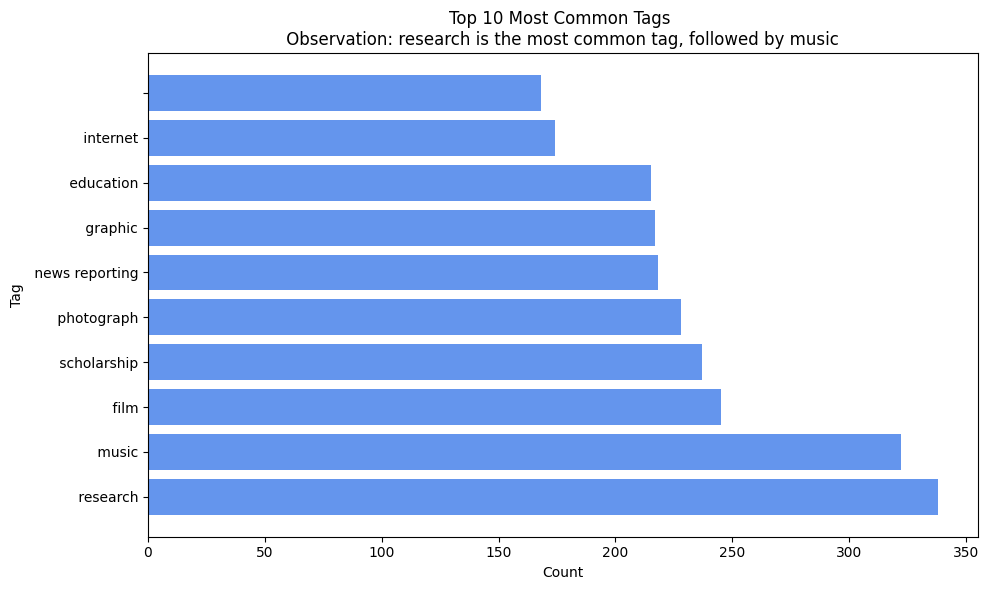

In [13]:
# Ensure tags column is treated as strings and handle NaN values
data['tags'] = data['tags'].fillna('').astype(str)

# Create a single flat list of all tags for counting
all_tags_flat = [tag for tags in data['tags'] for tag in tags.split(',')]

# Count the frequency of each tag
tag_counter = Counter(all_tags_flat)

# Display the top 10 most common tags
most_common_tags = tag_counter.most_common(10)

# Plot the most common tags
fig, ax = plt.subplots(figsize=(10, 6))
tags, counts = zip(*most_common_tags)
ax.barh(tags, counts, color='cornflowerblue')
ax.set_xlabel('Count')
ax.set_ylabel('Tag')
ax.set_title('Top 10 Most Common Tags \n Observation: research is the most common tag, followed by music ')
plt.tight_layout()
plt.show()


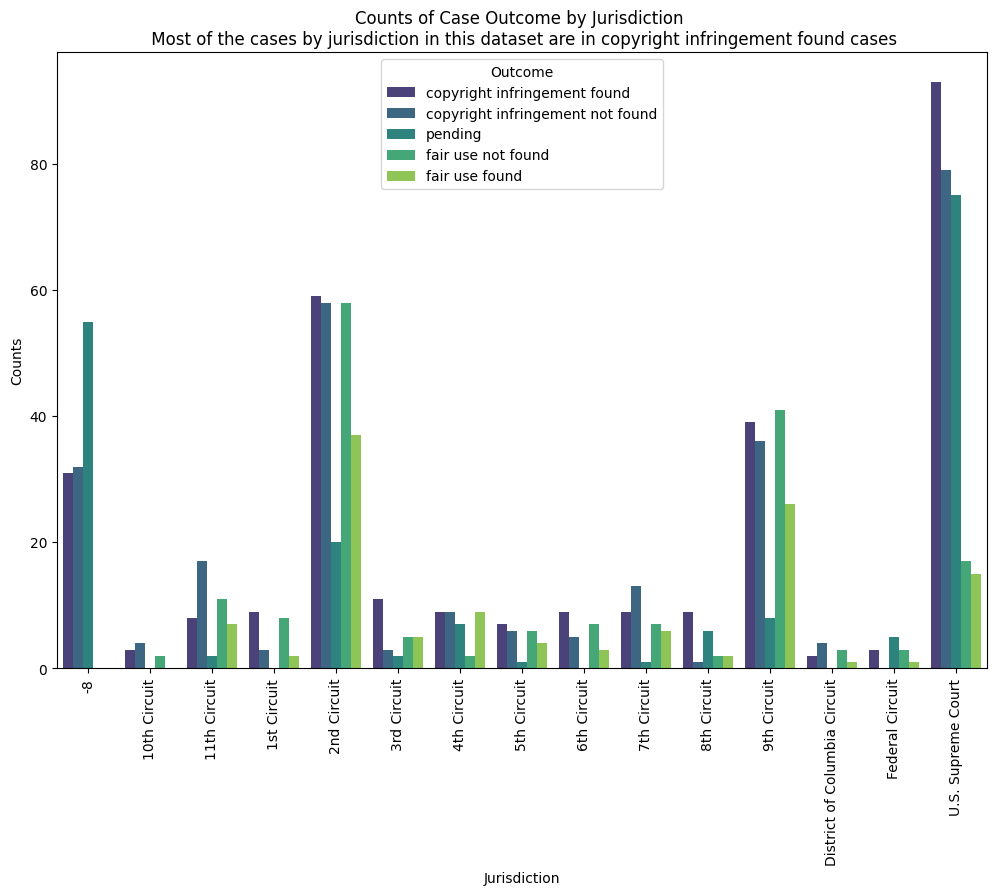

In [14]:
agg_data = data.groupby(['jurisdiction', 'outcome']).size().reset_index(name='counts')

# Plot the data
plt.figure(figsize=(12, 8))
sns.barplot(x='jurisdiction', y='counts', hue='outcome', data=agg_data, palette='viridis')
plt.title('Counts of Case Outcome by Jurisdiction \n Most of the cases by jurisdiction in this dataset are in copyright infringement found cases')
plt.xlabel('Jurisdiction')
plt.ylabel('Counts')
plt.xticks(rotation=90)  # Rotate the x labels for better visibility
plt.legend(title='Outcome')
plt.show()


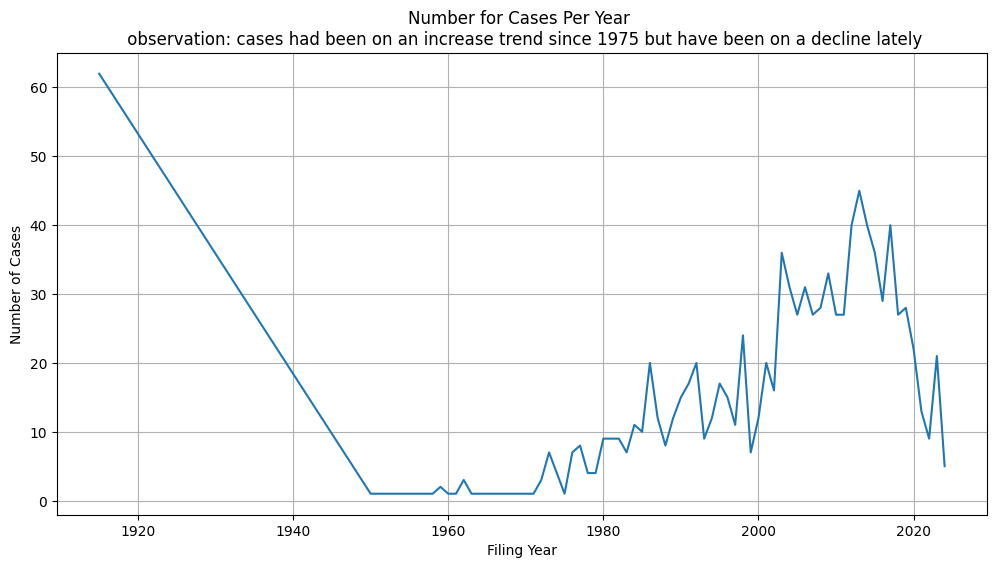

In [15]:
# Analyze the number of cases per year
plt.figure(figsize=(12, 6))
sns.lineplot(data=data['year'].value_counts().sort_index())
plt.title('Number for Cases Per Year \n observation: cases had been on an increase trend since 1975 but have been on a decline lately')
plt.xlabel('Filing Year')
plt.ylabel('Number of Cases')
plt.grid(True)
plt.show()

## Data Preparation

In [16]:
text_col = 'text'
categorical_cols = ['court', 'jurisdiction', 'tags']
numerical_cols = ['year','case_type_encoded']
target_col = 'outcome'

In [17]:
# set missing text and tags
data['text'] = data['text'].fillna('').astype(str)
data['tags'] = data['tags'].fillna('').astype(str)

In [18]:
# fill mising values
for col in categorical_cols:
    data[col] = data[col].fillna('missing').astype(str)
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].mean())

In [19]:
# define additional features
data['text_length'] = data[text_col].apply(lambda x: len(re.findall(r'\w+', str(x))))
data['sentiment'] = data[text_col].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
data['num_tags'] = data['tags'].groupby(data.index).transform('count')
numerical_cols.extend(['text_length', 'sentiment', 'num_tags'])

***define transformers***

In [20]:
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, text_col),
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ]
)

In [21]:
selected_features = categorical_cols + numerical_cols + [text_col]
X = data[selected_features].copy()
y = data[target_col].copy()

In [22]:
# Handle missing values in the target column if necessary
y = y.fillna('missing')

# Convert categorical target to numerical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#### Train/Test Split

In [23]:
# Split the imbalanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
#let's take a look
split_type = ['X_train', 'X_test','y_train','y_test']
shape_info = [X_train.shape, X_test.shape, y_train.shape, y_test.shape]
split_results_df = pd.DataFrame({'data_split': split_type, 'shape': shape_info})
split_results_df

,data_split,shape
0,X_train,"(834, 9)"
1,X_test,"(209, 9)"
2,y_train,"(834,)"
3,y_test,"(209,)"


In [25]:
X.columns

Index(['court', 'jurisdiction', 'tags', 'year', 'case_type_encoded',
       'text_length', 'sentiment', 'num_tags', 'text'],
      dtype='object')

***Define utility methods***

In [26]:
results = {}

def fit_predict(model_name, pipeline, params=None):
    if params is None:
        start = time()
        pipeline.fit(X_train, y_train)
        stop = time()
        best_model = pipeline
        best_params = 'default'
        best_score = accuracy_score(y_train, pipeline.predict(X_train))
    else:
        grid_search = GridSearchCV(pipeline, params, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
        start = time()
        grid_search.fit(X_train, y_train)
        stop = time()
        # Extract best results
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
    
    y_prd = best_model.predict(X_test)
    report = classification_report(y_test, y_prd, target_names=label_encoder.classes_)
    print(model_name, ": ", stop - start,"(s) best_params: ",best_params," best_score: ",best_score)
    results[model_name] = {
        'model_name': model_name,
        'y_pred' : y_prd,
        'best_model': best_model,
        'best_params': best_params,
        'best_score': best_score,
        'train_time': stop - start,
        'accuracy_on_test_data': accuracy_score(y_test, y_prd),
        'f1_score': f1_score(y_test, y_prd, average='weighted'),
        'report': report
    }
    print(report)

## Modeling

In [27]:
fit_predict('RandomForestClassifier', 
            Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier())]))

RandomForestClassifier :  9.66695237159729 (s) best_params:  default  best_score:  0.9964028776978417
                                  precision    recall  f1-score   support

    copyright infringement found       0.67      0.69      0.68        72
copyright infringement not found       0.64      0.72      0.68        47
                  fair use found       0.25      0.04      0.07        24
              fair use not found       0.49      0.71      0.58        34
                         pending       0.71      0.62      0.67        32

                        accuracy                           0.62       209
                       macro avg       0.55      0.56      0.54       209
                    weighted avg       0.59      0.62      0.59       209



In [28]:
fit_predict('LogisticRegression', 
            Pipeline(steps=[('preprocessor', preprocessor),('model', LogisticRegression(max_iter=1000))]))

LogisticRegression :  47.871641635894775 (s) best_params:  default  best_score:  0.935251798561151
                                  precision    recall  f1-score   support

    copyright infringement found       0.67      0.60      0.63        72
copyright infringement not found       0.54      0.74      0.62        47
                  fair use found       0.47      0.33      0.39        24
              fair use not found       0.54      0.59      0.56        34
                         pending       0.58      0.47      0.52        32

                        accuracy                           0.58       209
                       macro avg       0.56      0.55      0.55       209
                    weighted avg       0.58      0.58      0.57       209



In [29]:
fit_predict('KNN', Pipeline(steps=[('preprocessor', preprocessor),('model', KNeighborsClassifier())]))

KNN :  6.0645551681518555 (s) best_params:  default  best_score:  0.6378896882494005
                                  precision    recall  f1-score   support

    copyright infringement found       0.51      0.62      0.56        72
copyright infringement not found       0.37      0.53      0.43        47
                  fair use found       0.50      0.29      0.37        24
              fair use not found       0.43      0.29      0.35        34
                         pending       0.50      0.25      0.33        32

                        accuracy                           0.45       209
                       macro avg       0.46      0.40      0.41       209
                    weighted avg       0.46      0.45      0.44       209



In [30]:
fit_predict('Gradient Boosting', Pipeline(steps=[('preprocessor', preprocessor),('model', GradientBoostingClassifier())]))

Gradient Boosting :  81.53950333595276 (s) best_params:  default  best_score:  0.9964028776978417
                                  precision    recall  f1-score   support

    copyright infringement found       0.66      0.60      0.63        72
copyright infringement not found       0.58      0.81      0.67        47
                  fair use found       0.78      0.29      0.42        24
              fair use not found       0.60      0.71      0.65        34
                         pending       0.59      0.53      0.56        32

                        accuracy                           0.62       209
                       macro avg       0.64      0.59      0.59       209
                    weighted avg       0.63      0.62      0.61       209



In [31]:
fit_predict('SVM', Pipeline(steps=[('preprocessor', preprocessor),('model', SVC(kernel='linear', probability=True))]))

SVM :  21.27672266960144 (s) best_params:  default  best_score:  0.9568345323741008
                                  precision    recall  f1-score   support

    copyright infringement found       0.68      0.62      0.65        72
copyright infringement not found       0.59      0.72      0.65        47
                  fair use found       0.47      0.33      0.39        24
              fair use not found       0.57      0.62      0.59        34
                         pending       0.55      0.53      0.54        32

                        accuracy                           0.60       209
                       macro avg       0.57      0.57      0.56       209
                    weighted avg       0.60      0.60      0.59       209



### Hyperparameter tuning and grid search

In [32]:
# RandomForestClassifier
rfc_params = [{'model__n_estimators': [100, 200], 'model__max_depth': [None, 10, 20]}]
fit_predict('GridSearch with RandomForestClassifier', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', RandomForestClassifier())]),
                       rfc_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with RandomForestClassifier :  122.11999201774597 (s) best_params:  {'model__max_depth': 20, 'model__n_estimators': 100}  best_score:  0.6018469085924536
                                  precision    recall  f1-score   support

    copyright infringement found       0.72      0.72      0.72        72
copyright infringement not found       0.61      0.79      0.69        47
                  fair use found       0.50      0.08      0.14        24
              fair use not found       0.52      0.74      0.61        34
                         pending       0.75      0.56      0.64        32

                        accuracy                           0.64       209
                       macro avg       0.62      0.58      0.56       209
                    weighted avg       0.64      0.64      0.62       209



In [33]:
#LogisticRegression
lr_params = [{'model__penalty': ['l2'],'model__C': [0.1, 1, 10]}]
fit_predict('GridSearch with LogisticRegression', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', LogisticRegression())]), 
                       lr_params)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
GridSearch with LogisticRegression :  87.84124541282654 (s) best_params:  {'model__C': 1, 'model__penalty': 'l2'}  best_score:  0.5646850876560132
                                  precision    recall  f1-score   support

    copyright infringement found       0.67      0.60      0.63        72
copyright infringement not found       0.54      0.74      0.62        47
                  fair use found       0.47      0.33      0.39        24
              fair use not found       0.54      0.59      0.56        34
                         pending       0.58      0.47      0.52        32

                        accuracy                           0.58       209
                       macro avg       0.56      0.55      0.55       209
                    weighted avg       0.58      0.58      0.57       209



In [34]:
# KNN
knn_params = [{'model__n_neighbors': [3, 5, 7], 'model__weights': ['uniform', 'distance']}]
fit_predict('GridSearch with KNN', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', KNeighborsClassifier())]),
                       knn_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with KNN :  70.11420011520386 (s) best_params:  {'model__n_neighbors': 7, 'model__weights': 'distance'}  best_score:  0.4760118317581704
                                  precision    recall  f1-score   support

    copyright infringement found       0.57      0.58      0.58        72
copyright infringement not found       0.44      0.53      0.48        47
                  fair use found       0.45      0.21      0.29        24
              fair use not found       0.50      0.50      0.50        34
                         pending       0.52      0.53      0.52        32

                        accuracy                           0.51       209
                       macro avg       0.50      0.47      0.47       209
                    weighted avg       0.51      0.51      0.50       209



In [35]:
# GradientBoostingClassifier
param_grid = {
    'model__n_estimators': [50, 100],
    'model__learning_rate': [0.01, 0.1],
    'model__max_depth': [3, 4],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

fit_predict('GridSearch with GradientBoostingClassifier', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', GradientBoostingClassifier(random_state=42))]),
                       param_grid)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
GridSearch with GradientBoostingClassifier :  1815.638606786728 (s) best_params:  {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}  best_score:  0.6246591155039318
                                  precision    recall  f1-score   support

    copyright infringement found       0.65      0.61      0.63        72
copyright infringement not found       0.58      0.81      0.68        47
                  fair use found       0.67      0.25      0.36        24
              fair use not found       0.56      0.65      0.60        34
                         pending       0.61      0.53      0.57        32

                        accuracy                           0.61       209
                       macro avg       0.61      0.57      0.57       209
                    weighted avg       0.62      0.61      0.60       209



In [36]:
# SVM
svm_params = [{'model__C': [0.1, 1, 10],'model__kernel': ['linear', 'rbf']}]
fit_predict('GridSearch with SVM', 
                       Pipeline(steps=[('preprocessor', preprocessor),('model', SVC())]), 
                       svm_params)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch with SVM :  40.18874764442444 (s) best_params:  {'model__C': 10, 'model__kernel': 'rbf'}  best_score:  0.5563595700165933
                                  precision    recall  f1-score   support

    copyright infringement found       0.77      0.74      0.75        72
copyright infringement not found       0.60      0.81      0.69        47
                  fair use found       0.44      0.29      0.35        24
              fair use not found       0.53      0.56      0.54        34
                         pending       0.56      0.44      0.49        32

                        accuracy                           0.63       209
                       macro avg       0.58      0.57      0.57       209
                    weighted avg       0.62      0.63      0.62       209



### Results

In [37]:
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Best Params': [results[model]['best_params'] for model in results],
    'Fit Time (s)': [results[model]['train_time'] for model in results],
    'Train Accuracy': [results[model]['best_score'] for model in results],
    'Test Accuracy': [results[model]['accuracy_on_test_data'] for model in results],
    'F1 Score': [results[model]['f1_score'] for model in results]
})
HTML(results_df.to_html(classes='table table-stripped'))

,Model,Best Params,Fit Time (s),Train Accuracy,Test Accuracy,F1 Score
0,RandomForestClassifier,default,9.666952,0.996403,0.617225,0.591626
1,LogisticRegression,default,47.871642,0.935252,0.578947,0.574052
2,KNN,default,6.064555,0.637890,0.454545,0.441978
3,Gradient Boosting,default,81.539503,0.996403,0.617225,0.607080
4,SVM,default,21.276723,0.956835,0.598086,0.593986
5,GridSearch with RandomForestClassifier,"{'model__max_depth': 20, 'model__n_estimators': 100}",122.119992,0.601847,0.641148,0.616916
6,GridSearch with LogisticRegression,"{'model__C': 1, 'model__penalty': 'l2'}",87.841245,0.564685,0.578947,0.574052
7,GridSearch with KNN,"{'model__n_neighbors': 7, 'model__weights': 'distance'}",70.114200,0.476012,0.507177,0.500557
8,GridSearch with GradientBoostingClassifier,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}",1815.638607,0.624659,0.607656,0.595712
9,GridSearch with SVM,"{'model__C': 10, 'model__kernel': 'rbf'}",40.188748,0.556360,0.626794,0.618071


## Model Evaluation

<Figure size 800x800 with 0 Axes>

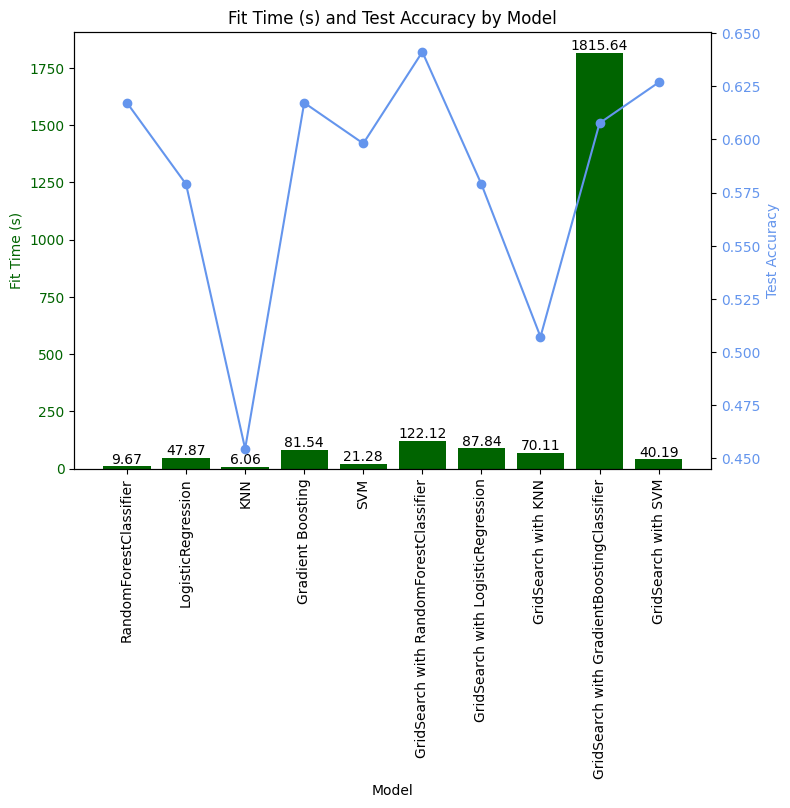

In [38]:
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('Model')
plt.xticks(rotation=90)

bars = ax.bar(results_df['Model'], results_df['Fit Time (s)'], color='darkgreen')
# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')


ax2 = ax.twinx()
ax2.plot(results_df['Model'], results_df['Test Accuracy'], color='cornflowerblue', marker='o')

ax.set_ylabel('Fit Time (s)', color='darkgreen')
ax2.set_ylabel('Test Accuracy', color='cornflowerblue')

ax.tick_params(axis='y', labelcolor='darkgreen')
ax2.tick_params(axis='y', labelcolor='cornflowerblue')

fig.tight_layout()
plt.title('Fit Time (s) and Test Accuracy by Model')
plt.show()

<Figure size 800x800 with 0 Axes>

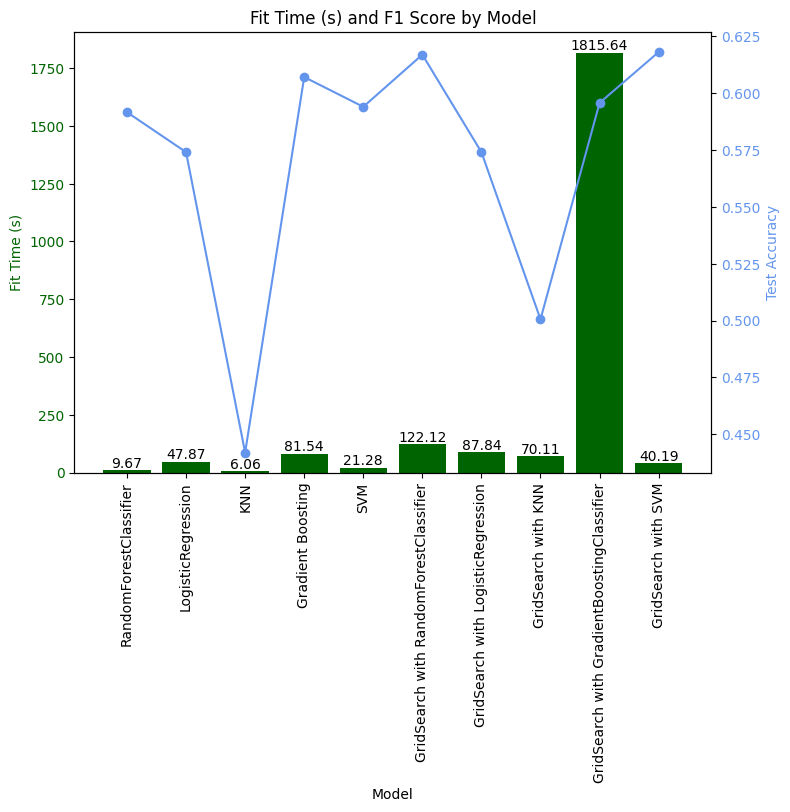

In [39]:
f1_score = [results[model]['f1_score'] for model in results]
plt.figure(figsize=(8, 8))
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('Model')
plt.xticks(rotation=90)

bars = ax.bar(results_df['Model'], results_df['Fit Time (s)'], color='darkgreen')
# Adding text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', color='black')


ax2 = ax.twinx()
ax2.plot(results_df['Model'], f1_score, color='cornflowerblue', marker='o')

ax.set_ylabel('Fit Time (s)', color='darkgreen')
ax2.set_ylabel('Test Accuracy', color='cornflowerblue')

ax.tick_params(axis='y', labelcolor='darkgreen')
ax2.tick_params(axis='y', labelcolor='cornflowerblue')

fig.tight_layout()
plt.title('Fit Time (s) and F1 Score by Model')
plt.show()